# Deep Learning Model for EEG Person Identification

This notebook implements a deep neural network to identify individuals based on their EEG signals.

## 1. Import Libraries

In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 2. Load the Data

Loading the preprocessed and normalized EEG data.

In [2]:
base_data_path = r'd:\EEG\1.0.0'  # Your path
dl_dir = os.path.join(base_data_path, 'deep_learning_data')

# Load the normalized data
X = np.load(os.path.join(dl_dir, 'X_normalized.npy'))
y = np.load(os.path.join(dl_dir, 'y_encoded.npy'))

# Store dimensions
input_dim = X.shape[1]  # 1280 features
num_classes = len(np.unique(y))  # 109 persons

## 3. Train/Test Split

Splitting data into training and testing sets with stratification to maintain class balance.

In [3]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

## 4. Build the Model

Creating a deep neural network with:
- **Input layer**: 512 neurons with ReLU activation
- **Hidden layers**: 256 and 128 neurons with batch normalization and dropout
- **Output layer**: 109 neurons (one per person) with softmax activation

**Regularization techniques**:
- Batch Normalization: Stabilizes learning
- Dropout: Prevents overfitting

In [4]:
model = Sequential([
    # Input layer
    Dense(512, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Hidden layer 1
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Hidden layer 2
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Output layer (109 persons)
    Dense(num_classes, activation='softmax')
])

model.summary()

c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 109)            │        14,061 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 837,741 (3.20 MB)

 Trainable params: 835,949 (3.19 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 5. Compile the Model

- **Optimizer**: Adam with learning rate 0.001
- **Loss**: Sparse Categorical Crossentropy (for integer labels)
- **Metrics**: Accuracy

In [5]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 6. Setup Training Callbacks

- **EarlyStopping**: Stops training if validation loss doesn't improve for 10 epochs
- **ReduceLROnPlateau**: Reduces learning rate when validation loss plateaus
- **ModelCheckpoint**: Saves the best model based on validation accuracy

In [6]:
# Create directory for saving models
model_dir = r'd:\EEG\models'
os.makedirs(model_dir, exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


## 7. Train the Model

Training for up to 100 epochs with batch size of 128.

In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
1084/1092 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5664 - loss: 1.9108
Epoch 1: val_accuracy improved from None to 0.93282, saving model to d:\EEG\models\best_model.keras
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7563 - loss: 1.0178 - val_accuracy: 0.9328 - val_loss: 0.2440 - learning_rate: 0.0010
Epoch 2/100
1087/1092 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9086 - loss: 0.3302
Epoch 2: val_accuracy improved from 0.93282 to 0.96991, saving model to d:\EEG\models\best_model.keras
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9158 - loss: 0.3022 - val_accuracy: 0.9699 - val_loss: 0.1128 - learning_rate: 0.0010
Epoch 3/100
1086/1092 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9392 - loss: 0.2108
Epoch 3: val_accuracy did not improve from 0.96991
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9400 - loss: 0.2084 - val_accuracy: 0.9595 - val_loss: 0.1305 - learning_rate: 0.0010
Epoch 4/100
1088/1092 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms

## 8. Visualize Training History

Plotting accuracy and loss curves to understand model performance during training.

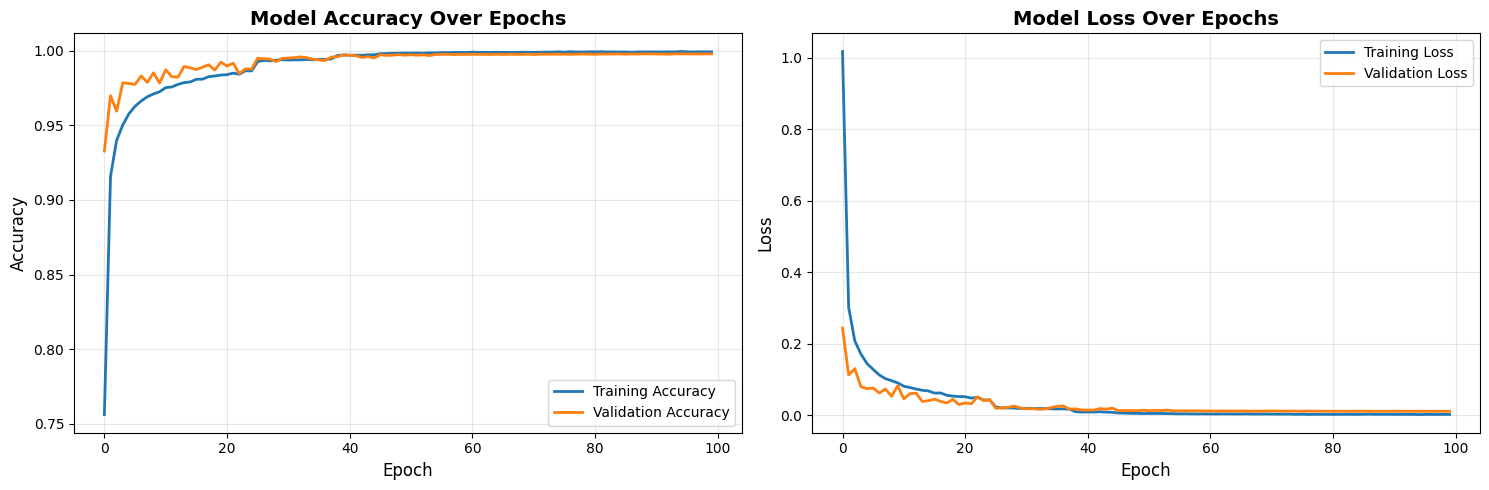

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()



## 9. Evaluate the Model

Testing the model on unseen data and computing performance metrics.

In [9]:
# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)

1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


## 10. Classification report 

Detailed classification report showing precision, recall, and F1-score for each person.

In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()
print(report_df.tail(3))  # Show macro avg, weighted avg, and accuracy



📋 CLASSIFICATION REPORT (Summary)
              precision    recall  f1-score       support
accuracy       0.997852  0.997852  0.997852      0.997852
macro avg      0.997868  0.997852  0.997855  34923.000000
weighted avg   0.997863  0.997852  0.997852  34923.000000

✅ Full classification report saved to CSV!


## 13. Save Final Model

Saving the trained model for future use.

In [11]:
# Save the final model
final_model_path = os.path.join(model_dir, 'eeg_person_identification_model.keras')
model.save(final_model_path)